<a href="https://colab.research.google.com/github/Nabila310/2025_Visi-Komputer_TI2A/blob/main/Jobsheet_03_Teknik_Regresi_Gambar_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Praktikum D2-Menebak Umur Manusia dari Foto Wajah(UTKFace)

In [1]:
# Jalankan ini di awal notebook
from google.colab import files
files.upload()  # pilih file kaggle.json dari komputer Anda


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nabilaramadani","key":"9783115b33e8e7597deb58fbc73c83d9"}'}

In [2]:
import os, shutil

if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("kaggle.json belum ditemukan. Upload terlebih dahulu.")


✅ Kaggle API siap digunakan.


In [3]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


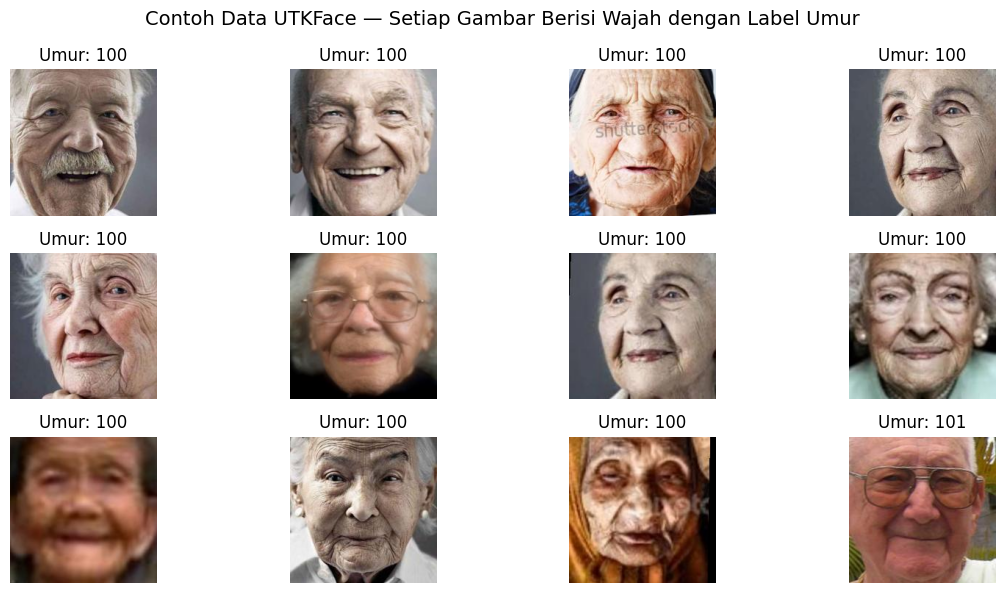

In [2]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")

plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()


In [3]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)

train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160

def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")


✅ Dataset siap dilatih.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)  # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])

model.summary()


Hardware: GPU


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 139ms/step - loss: 363.0663 - mae: 14.0476 - val_loss: 162.2027 - val_mae: 9.7104 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 158.6765 - mae: 9.4007 - val_loss: 148.8625 - val_mae: 9.2153 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 146.6719 - mae: 8.9325 - val_loss: 141.9007 - val_mae: 8.8734 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 141.6318 - mae: 8.7468 - val_loss: 142.1076 - val_mae: 8.8970 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - loss: 140.4494 - mae: 8.7039 - val_loss: 139.7567 - val_mae: 8.8124 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 136.7712 - mae: 8.6064 - val_loss: 139.5733 - val_mae: 8.7890 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 135.7894 - mae: 8.5499 - val_loss: 136.3838 - va

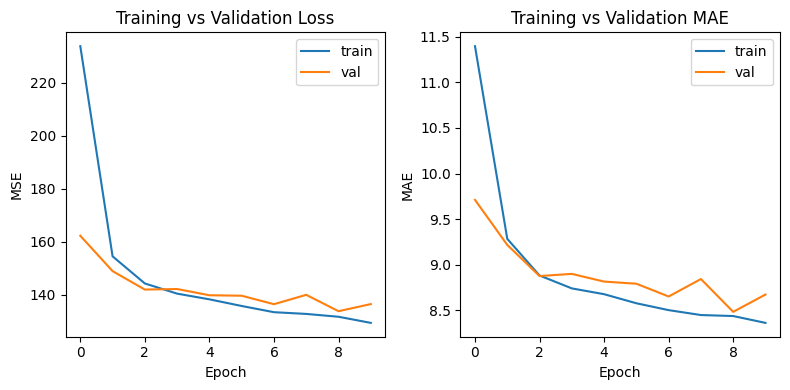

In [5]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - loss: 189.2229 - mae: 10.1601 - val_loss: 157.3580 - val_mae: 9.3823 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 78.0635 - mae: 6.5817 - val_loss: 121.6578 - val_mae: 8.4510 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - loss: 51.4960 - mae: 5.4124 - val_loss: 111.5101 - val_mae: 7.8120 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - loss: 36.4815 - mae: 4.6136 - val_loss: 107.4229 - val_mae: 7.6558 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - loss: 29.8009 - mae: 4.1704 - val_loss: 104.9569 - val_mae: 7.6461 - learning_rate: 1.0000e-04


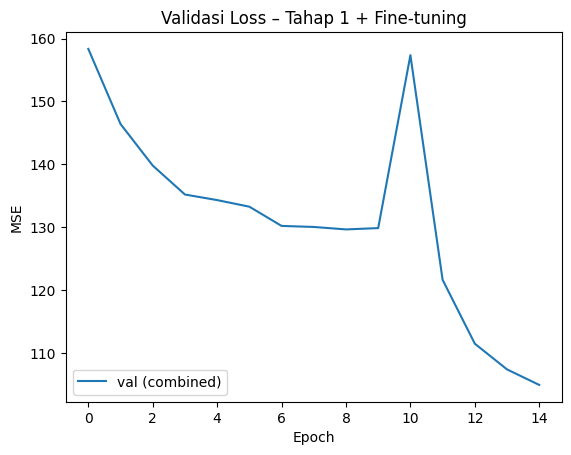

In [8]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


MAE  = 21.48 tahun
RMSE = 26.90 tahun
R²   = -0.823


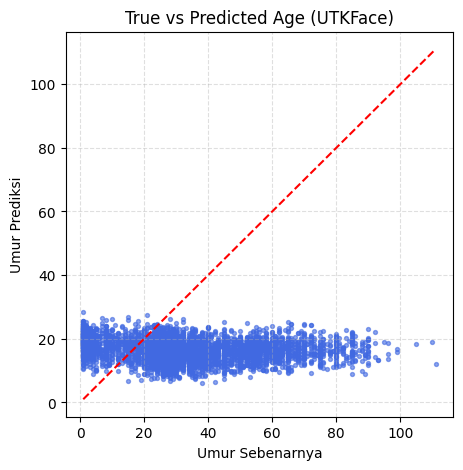

In [14]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE  = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R²   = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


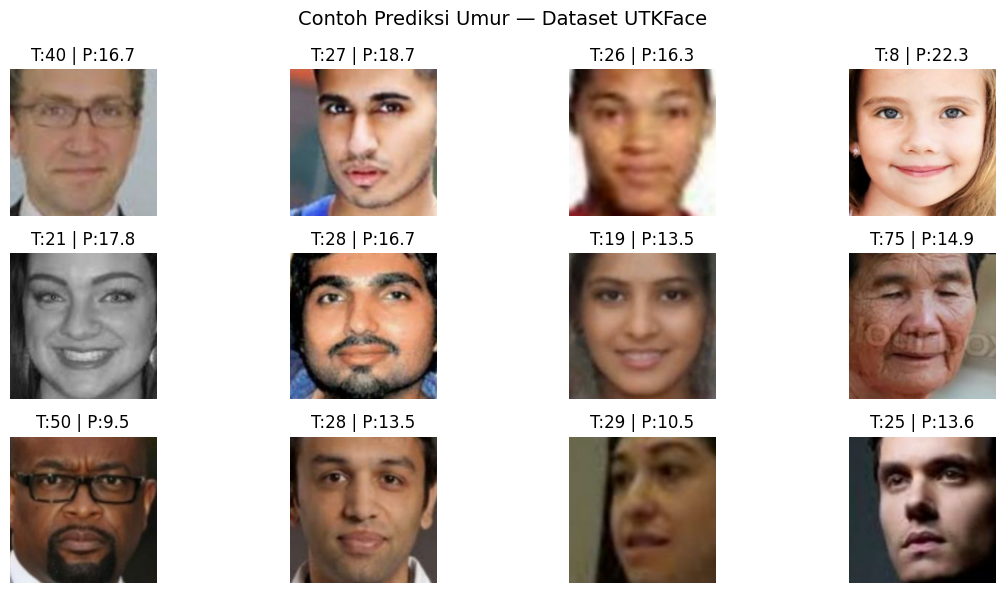

In [15]:
import random

sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12, 6))
for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()


Tantangan Mini

1. Tambahkan data augmentation ekstra (kontras, brightness, zoom)

In [20]:
from tensorflow.keras import layers

# augmentation layer
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1) if hasattr(layers, "RandomBrightness") else layers.RandomContrast(0.05)
], name="data_augment")

# rebuild dataset pipeline with augmentation applied to training set
def load_img_aug(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = data_augment(img)
    return img, label

train_ds_aug = tf.data.Dataset.from_tensor_slices((train_files, y_train)) \
    .map(load_img_aug, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

# Re-train head only quickly (use fewer epochs for demo)
model_aug = tf.keras.models.clone_model(model)  # clone architecture (weights not preserved)
# compile and set base_model freeze as earlier
base_model = model.layers[1] if len(model.layers) > 1 else None
# simpler: recompile existing model and fit with augmented ds (small epochs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
history_aug = model.fit(train_ds_aug, validation_data=test_ds, epochs=5, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])


Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 140s 375ms/step - loss: 474.3310 - mae: 16.6717 - val_loss: 400.6189 - val_mae: 15.8845
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 137s 376ms/step - loss: 420.7828 - mae: 15.7433 - val_loss: 397.8749 - val_mae: 15.7261
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 147s 409ms/step - loss: 421.1000 - mae: 15.7855 - val_loss: 399.0949 - val_mae: 15.1625
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 157s 436ms/step - loss: 419.0473 - mae: 15.6717 - val_loss: 395.0197 - val_mae: 15.5302
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 138s 377ms/step - loss: 421.0015 - mae: 15.7174 - val_loss: 396.2146 - val_mae: 15.2753


2. Ubah learning rate schedule atau optimizer

In [21]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt, loss='mse', metrics=['mae'])

history_sched = model.fit(train_ds, validation_data=test_ds, epochs=6, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])


Epoch 1/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - loss: 393.7103 - mae: 15.1741 - val_loss: 372.2533 - val_mae: 15.0215
Epoch 2/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - loss: 381.7762 - mae: 14.8740 - val_loss: 365.1225 - val_mae: 14.8710
Epoch 3/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - loss: 375.3962 - mae: 14.7177 - val_loss: 362.0394 - val_mae: 14.8807
Epoch 4/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 371.0024 - mae: 14.6239 - val_loss: 358.8241 - val_mae: 14.8401
Epoch 5/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - loss: 367.6329 - mae: 14.5552 - val_loss: 354.9834 - val_mae: 14.7110
Epoch 6/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - loss: 364.4287 - mae: 14.4864 - val_loss: 351.5148 - val_mae: 14.6865


3. Pisahkan dataset per kelompok umur dan hitung MAE per kelompok (0–10,11–20,...)

In [1]:
# D2-Challenge 3: evaluate per age group
import pandas as pd

df_test = pd.DataFrame({'path': test_files, 'age': y_test})
bins = list(range(0, 101, 10))  # 0-9,10-19,...
labels = [f"{b}-{b+9}" for b in bins[:-1]]
df_test['age_group'] = pd.cut(df_test['age'], bins=bins, labels=labels, right=False)

# Predict all test images
y_pred_all = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
test_order = []
for batch in test_ds:
    for p in batch[0].numpy():
        test_order.append(p)

y_preds_list = []
for fp in df_test['path'].values:
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    pred = model.predict(tf.expand_dims(img,0), verbose=0).ravel()[0]
    y_preds_list.append(pred)
df_test['pred'] = y_preds_list


group_mae = df_test.groupby('age_group').apply(lambda g: mean_absolute_error(g['age'], g['pred']))
print("MAE per age group:")
print(group_mae)


NameError: name 'test_files' is not defined

4. Uji model pada foto pribadi (ganti path ke foto kamu)

In [ ]:
# D2-Challenge 4: predict your own image
YOUR_IMAGE_PATH = "/content/Nabila.jpeg"  # <-- ganti dengan path file kamu setelah upload

from PIL import Image
if os.path.exists(YOUR_IMAGE_PATH):
    img = tf.io.read_file(YOUR_IMAGE_PATH)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    pred_age = model.predict(tf.expand_dims(img,0), verbose=0).ravel()[0]
    print(f"Predicted age: {pred_age:.2f} years")
    # show image
    display(Image.open(YOUR_IMAGE_PATH).resize((200,200)))
else:
    print(f"File not found at {YOUR_IMAGE_PATH}. Upload your image to this path first.")


Praktikum D1-Regresi dan Citra Sintesis(Prediksi Radius lingkaran)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1)  # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)  # center-x
    cy = np.random.randint(r, img_size - r)  # center-y
    cv2.circle(img, (cx, cy), r, (255,), -1)  # lingkaran putih terisi
    img = (img / 255.0).astype(np.float32)
    # 3-channel biar kompatibel CNN
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)


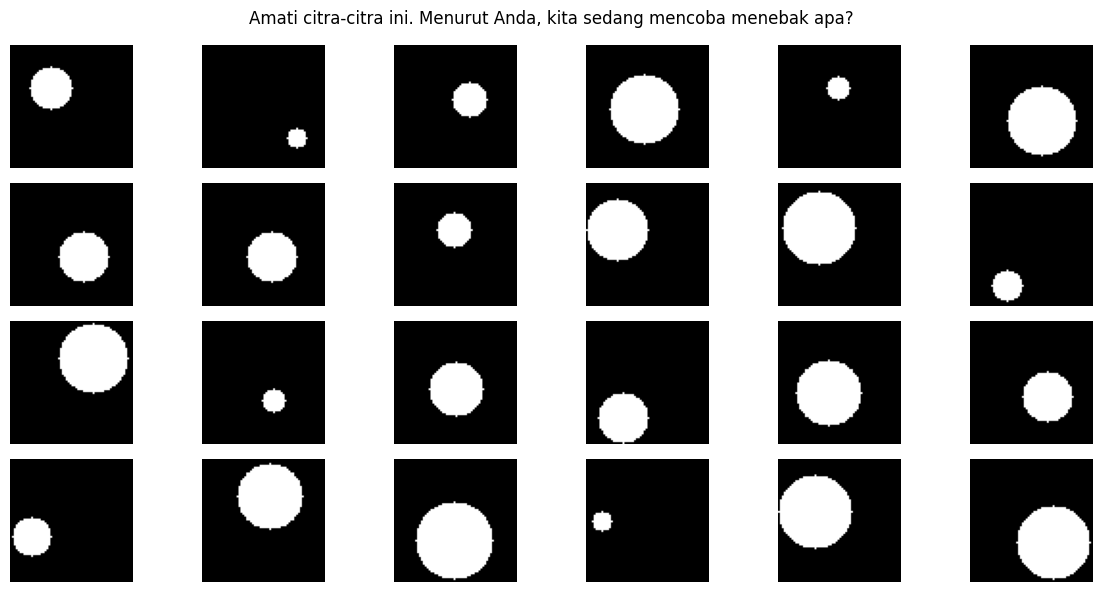

In [10]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label
cols = 6
rows = N_show // cols

plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()


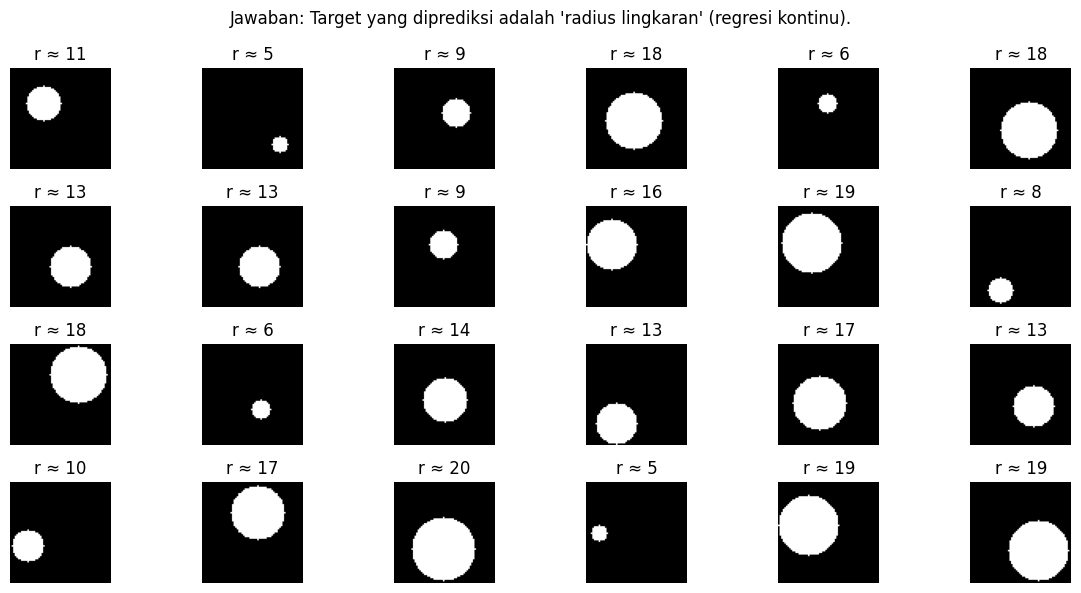

In [11]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')

plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()


In [12]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=12,
    batch_size=64,
    verbose=1
)


Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 96.5003 - mae: 8.1229 - val_loss: 2.9735 - val_mae: 1.3690
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.8764 - mae: 1.3549 - val_loss: 1.5996 - val_mae: 1.0253
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.4914 - mae: 1.0038 - val_loss: 1.5339 - val_mae: 1.0149
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.5795 - mae: 1.0327 - val_loss: 1.4998 - val_mae: 1.0049
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5204 - mae: 1.0045 - val_loss: 1.4680 - val_mae: 0.9993
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4305 - mae: 0.9682 - val_loss: 1.4471 - val_mae: 1.0017
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5071 - mae: 1.0009 - val_loss: 1.4697 - val_mae: 1.0195
Epoch 8/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4416 - mae: 0.9755 - val_loss: 1.4133 - val_mae: 0.9910
Epoch 9/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.47

In [17]:
# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)

print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAE=0.949 | RMSE=1.198 | R²=0.928


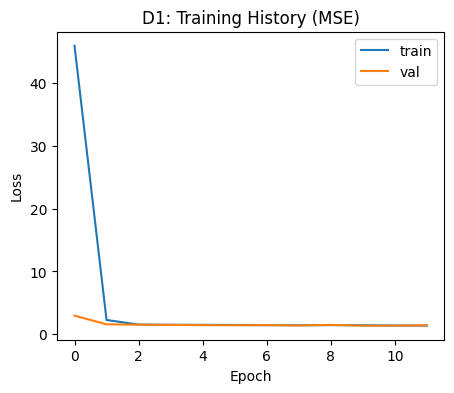

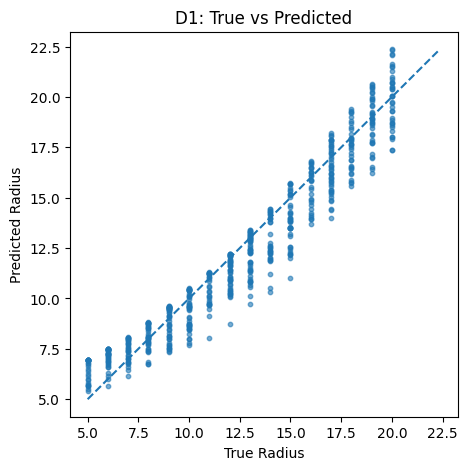

In [18]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Scatter True vs Predicted
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius")
plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()
